In [16]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from utils import CampaignDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset

path = "campaign_performance.xlsx"

df_campaigns = pd.read_excel(path,sheet_name="campaigns")
df_metrics = pd.read_excel(path, sheet_name="campaign_metrics")
df_transactions = pd.read_excel(path, sheet_name="transactions")

In [3]:
preferences = {
    "Generation Z": {
        "Age Range": (18, 27),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.2, 0.1], # Probability to buy = 20%, spending deviation=10%
                "Health and Beauty": [0.15, 0.1],  
                "Electronics": [0.65, 0.2],  
            },
            "Female": {
                "Groceries": [0.25, 0.1],
                "Health and Beauty": [0.6, 0.15],  
                "Electronics": [0.15, 0.1],
            },
        },
    },
    "Millennials": {
        "Age Range": (28, 40),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.3, 0.15],
                "Health and Beauty": [0.2, 0.2],
                "Electronics": [0.5, 0.25],
            },
            "Female": {
                "Groceries": [0.35, 0.2],
                "Health and Beauty": [0.45, 0.2],
                "Electronics": [0.2, 0.15],
            },
        },
    },
    "Generation X": {
        "Age Range": (41, 55),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.4, 0.2],
                "Health and Beauty": [0.25, 0.15],
                "Electronics": [0.35, 0.3],
            },
            "Female": {
                "Groceries": [0.45, 0.25],
                "Health and Beauty": [0.35, 0.2],
                "Electronics": [0.2, 0.15],
            },
        },
    },
    "Boomers": {
        "Age Range": (56, 65),
        "Shopping Preference": {
            "Male": {
                "Groceries": [0.5, 0.3],
                "Health and Beauty": [0.35, 0.2],
                "Electronics": [0.15, 0.1],
            },
            "Female": {
                "Groceries": [0.55, 0.3],
                "Health and Beauty": [0.3, 0.2],
                "Electronics": [0.15, 0.1],
            },
        },
    },
}

age_distribution = [
        (18, 19, 7.36), 
        (20, 24, 8.68),
        (25, 29, 8.92),
        (30, 34, 6.97),
        (35, 39, 6.91),
        (40, 44, 5.15),
        (45, 49, 4.16),
        (50, 54, 2.99),
        (55, 59, 2.42),
        (60, 65, 1.83) 
    ]

dow_weights = {
            0: 0.9,  # Monday
            1: 0.95, # Tuesday
            2: 1.0,  # Wednesday
            3: 1.0,  # Thursday
            4: 1.1,  # Friday
            5: 1.3,  # Saturday
            6: 1.2   # Sunday
        }

In [4]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
fake = Faker()
Faker.seed(SEED)

# Select campaign_id
CAMPAIGN_ID = 303


# Set the click conversion rate
CLICK_CONVERSION = 0.07


In [ ]:
def generate_sensitivity_analysis(df_campaigns, df_metrics, df_transactions, simul_param):
    
    # Merge and calculate relevant metrics
    df_campaigns_metrics = pd.merge(df_campaigns, df_metrics,how="left", on="campaign_id")
    df_campaigns_metrics["CTR"] = df_campaigns_metrics["Clicks"] / df_campaigns_metrics["Impressions"]
    df_campaigns_metrics["CPI"] = df_campaigns_metrics['budget'] / df_campaigns_metrics['Impressions']

    # Select reference campaign
    selected_campaign = df_campaigns_metrics[df_campaigns_metrics["campaign_id"] == CAMPAIGN_ID]

    # Calculate simulated metrics
    sim_impressions = int((selected_campaign['budget'].iloc[0] + simul_param['budget_increase']) / selected_campaign['CPI'].iloc[0])
    sim_clicks = int(sim_impressions * (selected_campaign["CTR"].iloc[0] + simul_param['expected_ctr_inc']))
    sim_hits = int((selected_campaign['website_landing_hits'].iloc[0] / selected_campaign['Impressions'].iloc[0]) * sim_impressions)

    simulated_metrics = {
        "campaign_id":simul_param['simulated_id'],
        "Clicks": sim_clicks,
        "Impressions": sim_impressions,
        "website_landing_hits": sim_hits
    }
    
    simulated_campaign = {col:selected_campaign[col].iloc[0] for col in df_campaigns.columns}

    simulated_campaign['campaign_id'] = simul_param['simulated_id']
    simulated_campaign['budget'] = simulated_campaign["budget"] + simul_param['budget_increase']
    
    # Add the simulated campaign into the dataframe
    df_metrics_sim = pd.concat([df_metrics, pd.DataFrame([simulated_metrics])], ignore_index=True)
    df_campaigns_sim = pd.concat([df_campaigns, pd.DataFrame([simulated_campaign])], ignore_index=True)
    
    # Setup the dataset class
    campaign_dataset = CampaignDataset(df_campaigns=df_campaigns_sim,
                                    df_metrics=df_metrics_sim,
                                    df_transactions=df_transactions,
                                    )
    
    # Simulate the daily metrics and interpolate the transactions
    campaign_dataset.simulate_daily_metrics(simul_param['simulated_id'], dow_weights)
    extrapolated_transaction = campaign_dataset.generate_synthetic_transactions(simul_param['simulated_id'], preferences, age_distribution, CLICK_CONVERSION)
    
    # Get relevant columns
    relevant_cols = ["campaign_id", "budget", "Clicks", "Impressions", "website_landing_hits", "total_transaction_amount","aov","total_unique_transactions"]
    
    # Get the metrics and campaign data
    campaign_metrics = campaign_dataset._merge_campaigns_and_metrics()
    
    # Get the total campaign transactions
    total_campaign_transactions = extrapolated_transaction.groupby(by="campaign_id").agg(
        total_transaction_amount=("amount","sum"),
        aov = ("amount", "mean"),
        total_unique_transactions=("transaction_id","count")
    ).reset_index()
    
    # Join the two datasets
    campaign_metrics_transactions = pd.merge(left=campaign_metrics, right=total_campaign_transactions, how="inner", on="campaign_id")[relevant_cols]
    
    # Marketing Cost per Transaction is budget divided by total unique transactions
    campaign_metrics_transactions["CPT"] = campaign_metrics_transactions["budget"] / campaign_metrics_transactions["total_unique_transactions"]
    
    # ROI assuming average profit of 10%
    profit_margin = .1
    campaign_metrics_transactions["Profit"] = ((campaign_metrics_transactions["total_transaction_amount"] * profit_margin) - campaign_metrics_transactions["budget"])
    campaign_metrics_transactions["ROI"] =  campaign_metrics_transactions["Profit"]/(
                                            campaign_metrics_transactions["budget"] + (campaign_metrics_transactions["total_transaction_amount"] * (1-profit_margin))
                                            )
    # Calculate ratio of CPT per AOV
    campaign_metrics_transactions["CPT/AOV"] = campaign_metrics_transactions["CPT"] / campaign_metrics_transactions['aov']

    campaign_metrics_transactions['CTR'] = campaign_metrics_transactions['Clicks'] / campaign_metrics_transactions['Impressions']
    campaign_metrics_transactions['sim_increased_ctr'] = simul_param['expected_ctr_inc']
    return campaign_metrics_transactions


In [ ]:
# Simulation parameters
simulated_id = 309
n_runs = 1000

max_budget = 1000
budget_interval = 100
max_ctr = .1
ctr_interval = .01

budget_increase = np.arange(0,max_budget+budget_interval,budget_interval)
expected_ctr_inc = np.arange(0, max_ctr+ctr_interval, ctr_interval)

param_comb = []
for budget in budget_increase:
    for ctr in expected_ctr_inc:
        param_comb.append([budget, ctr])


output_df = pd.DataFrame()
for _ in tqdm(range(n_runs)):
    for combination in param_comb:
        simul_param = {
            'simulated_id':simulated_id,
            'budget_increase':combination[0],
            'expected_ctr_inc':combination[1]
        }

        simul_df = generate_sensitivity_analysis(df_campaigns, df_metrics, df_transactions, simul_param)

        output_df = pd.concat([output_df, simul_df])



In [ ]:
# Pivot the data
pivot_roi = output_df.pivot_table(values='ROI', index='sim_increased_ctr', columns='budget', aggfunc='mean')
pivot_cpt = output_df.pivot_table(values='CPT', index='sim_increased_ctr', columns='budget', aggfunc='mean')

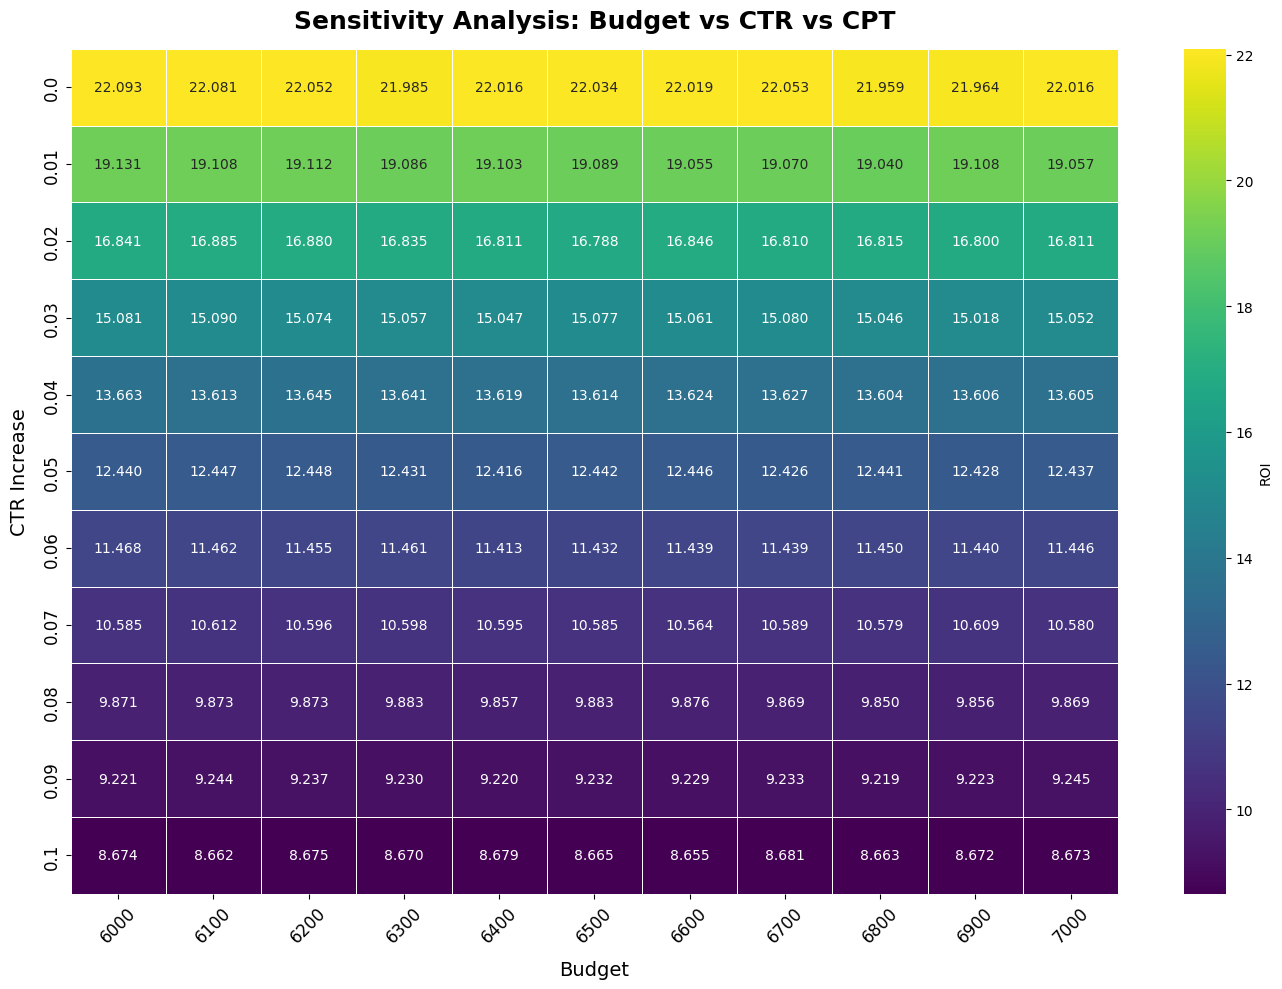

In [31]:
plt.figure(figsize=(14,10))

# Create a heatmap
sns.heatmap(
    pivot_cpt, 
    annot=True, 
    fmt=".3f", 
    cmap="viridis", 
    cbar_kws={'label': 'ROI', 'orientation': 'vertical'}, 
    annot_kws={"size": 10},  
    linewidths=0.5  
)

plt.title('Sensitivity Analysis: Budget vs CTR vs CPT', fontsize=18, weight='bold', pad=15)
plt.xlabel('Budget', fontsize=14, labelpad=10)
plt.ylabel('CTR Increase', fontsize=14, labelpad=10)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)


plt.tight_layout()

plt.show()

In [11]:
output_df

,campaign_id,budget,Clicks,Impressions,website_landing_hits,total_transaction_amount,aov,total_unique_transactions,CPT,Profit,ROI,CPT/AOV,CTR,sim_increased_ctr
0,309,6000,4000,60000,48310,80260,286.642857,280,21.428571,2026.0,0.025897,0.074757,0.066667,0.00
0,309,6000,4600,60000,48310,88104,294.662207,299,20.066890,2810.4,0.032950,0.068101,0.076667,0.01
0,309,6000,5200,60000,48310,102496,290.356941,353,16.997167,4249.6,0.043255,0.058539,0.086667,0.02
0,309,6000,5800,60000,48310,113875,296.549479,384,15.625000,5387.5,0.049660,0.052689,0.096667,0.03
0,309,6000,6400,60000,48310,126697,278.454945,455,13.186813,6669.7,0.055568,0.047357,0.106667,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,309,7000,8866,70000,56361,178899,291.366450,614,11.400651,10889.9,0.064817,0.039128,0.126657,0.06
0,309,7000,9566,70000,56361,188576,286.154780,659,10.622155,11857.6,0.067099,0.037120,0.136657,0.07
0,309,7000,10266,70000,56361,215961,282.301961,765,9.150327,14596.1,0.072486,0.032413,0.146657,0.08
0,309,7000,10966,70000,56361,211417,288.034060,734,9.536785,14141.7,0.071685,0.033110,0.156657,0.09
